# Time Series Anomaly Detection

In [53]:
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from env import get_connection

warnings.filterwarnings("ignore")

### 1)
   The dataset for these exercises lives in the Codeup Data Science MySQL Server. The database name is curriculum_logs.

Go through the lesson commenting code, adding docstrings, and adding markdown to support what is happening.

## Acquire

In [54]:
url = get_connection('curriculum_logs')
query = '''
SELECT *
FROM cohorts
'''

In [55]:
df = pd.read_sql(query, url)

In [56]:
df.head()

,id,name,slack,start_date,end_date,created_at,updated_at,deleted_at,program_id
0,1,Arches,#arches,2014-02-04,2014-04-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
1,2,Badlands,#badlands,2014-06-04,2014-08-22,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
2,3,Carlsbad,#carlsbad,2014-09-04,2014-11-05,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
3,4,Denali,#denali,2014-10-20,2015-01-18,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1
4,5,Everglades,#everglades,2014-11-18,2015-02-24,2016-06-14 19:52:26,2016-06-14 19:52:26,None,1


## Prepare

##### changing 4 date columns from object to datetime type.

In [57]:
df['start_date'] = pd.to_datetime(df['start_date'])
df['end_date'] = pd.to_datetime(df['end_date'])
df['created_at'] = pd.to_datetime(df['created_at'])
df['updated_at'] = pd.to_datetime(df['updated_at'])
df = df.set_index(df.start_date)

In [58]:
cohort = df['name'].resample('d').count()

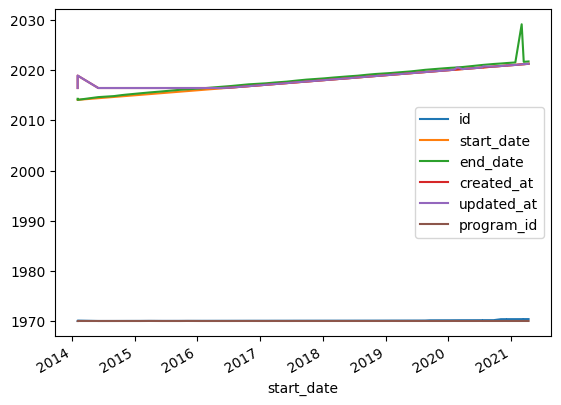

In [59]:
df.plot()
plt.show()

### Exponential Moving Average

In [60]:
# 7 day EMA
c_7d = cohort.ewm(span=7).mean()
c_7d.head()

start_date
2014-02-04    2.000000
2014-02-05    0.857143
2014-02-06    0.486486
2014-02-07    0.308571
2014-02-08    0.207426
Freq: D, Name: name, dtype: float64

In [61]:
#So if the span is 7 days, but there is only one day of data available (i.e. the first day), the EMA will equal the first value.
c_7d[0] == cohort[0]

True

In [62]:
# 14 day EMA
c_14d = cohort.ewm(span=14).mean()
c_14d.head()

start_date
2014-02-04    2.000000
2014-02-05    0.928571
2014-02-06    0.573854
2014-02-07    0.398296
2014-02-08    0.294381
Freq: D, Name: name, dtype: float64

In [63]:
# 30 day EMA
c_30d = cohort.ewm(span=30).mean()
c_30d.head()

start_date
2014-02-04    2.000000
2014-02-05    0.966667
2014-02-06    0.622732
2014-02-07    0.451147
2014-02-08    0.348500
Freq: D, Name: name, dtype: float64

In [64]:
# 90 day EMA
c_90d = cohort.ewm(span=90).mean()
c_90d.head()

start_date
2014-02-04    2.000000
2014-02-05    0.988889
2014-02-06    0.651907
2014-02-07    0.483458
2014-02-08    0.382422
Freq: D, Name: name, dtype: float64

### plot our EMAs against each other

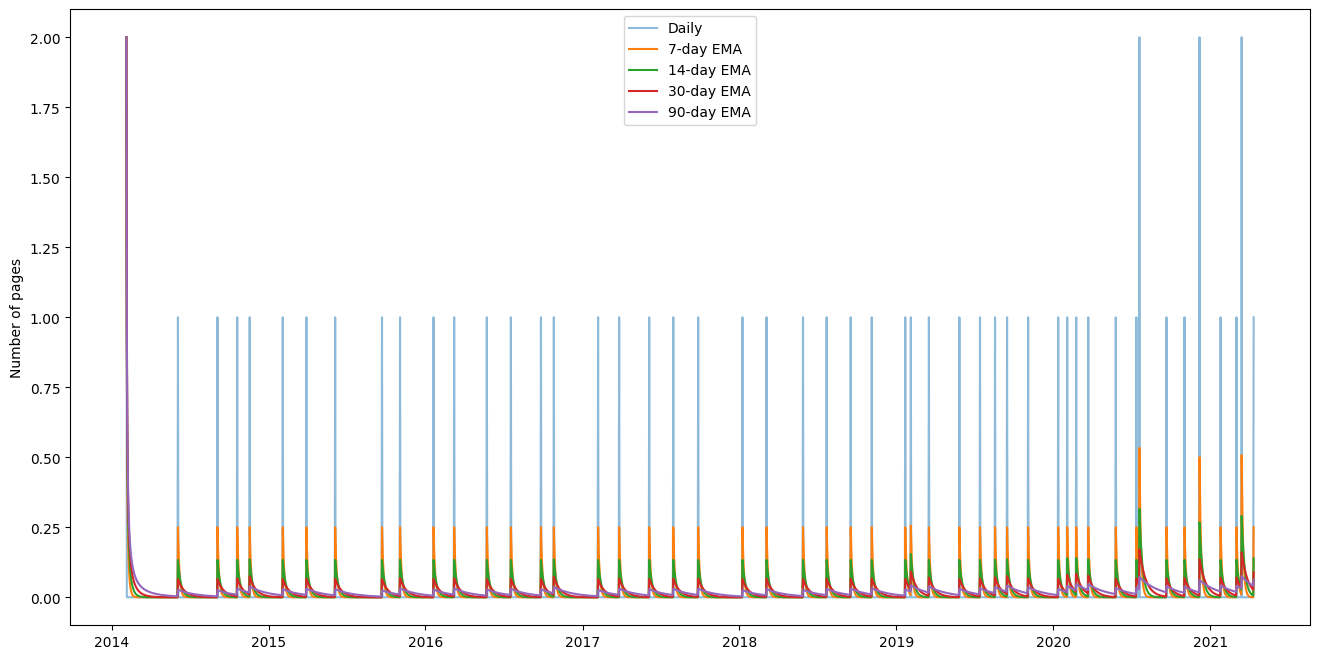

In [65]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(cohort.index, cohort, label='Daily', alpha=.5)

ax.plot(cohort.index, c_7d, label = '7-day EMA')
ax.plot(cohort.index, c_14d, label = '14-day EMA')
ax.plot(cohort.index, c_30d, label = '30-day EMA')
ax.plot(cohort.index, c_90d, label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

### looking at a smaller date range to see how these EMAs react to changes in value.

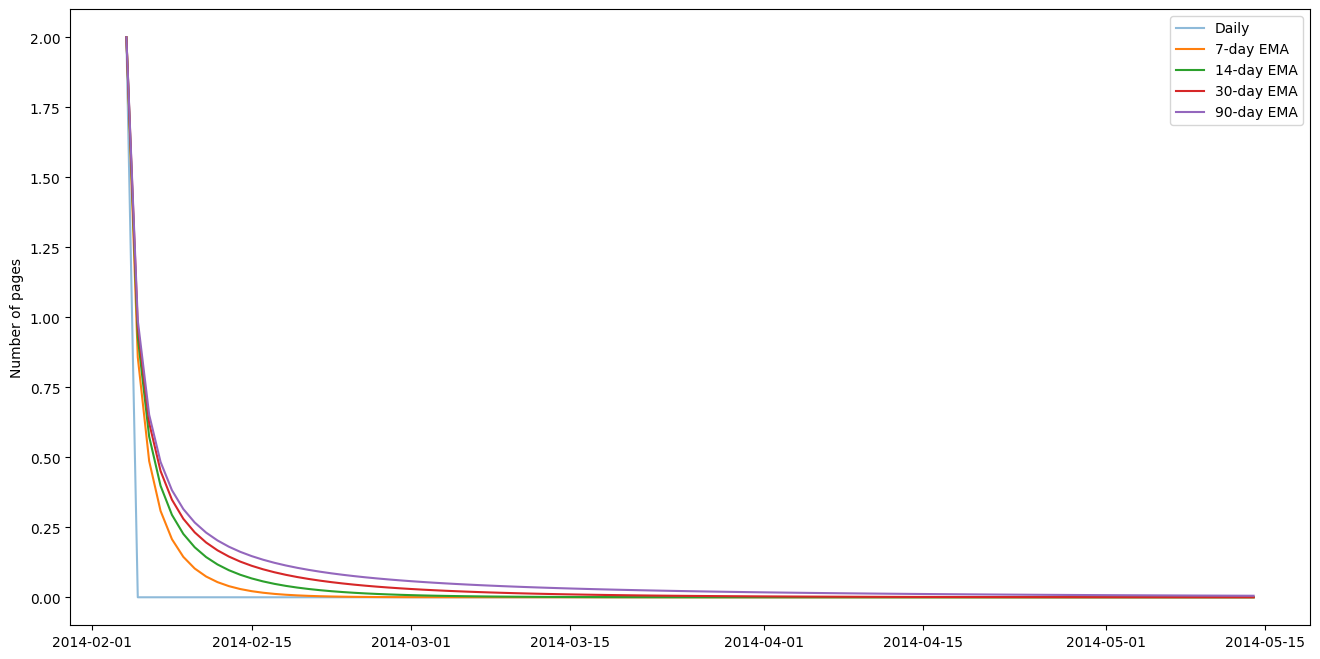

In [66]:
fig, ax = plt.subplots(figsize=(16,8))

ax.plot(cohort.index[:100], cohort[:100], label='Daily', alpha=.5)
ax.plot(cohort.index[:100], c_7d[:100], label = '7-day EMA')
ax.plot(cohort.index[:100], c_14d[:100], label = '14-day EMA')
ax.plot(cohort.index[:100], c_30d[:100], label = '30-day EMA')
ax.plot(cohort.index[:100], c_90d[:100], label = '90-day EMA')

ax.legend(loc='best')
ax.set_ylabel('Number of pages')

plt.show()

## Bollinger Bands

In [68]:
# setting the window span
span = 30

In [71]:
# compute midband
midband = cohort.ewm(span=span).mean()

In [72]:
# compute exponential stdev
stdev = cohort.ewm(span=span).std()

In [73]:
# compute upper and lower bands
ub = midband + stdev*3
lb = midband - stdev*3

In [74]:
# concatenate ub and lb together into one df, bb
bb = pd.concat([ub, lb], axis=1)

bb.columns = ['ub', 'lb']

In [75]:
my_df = pd.concat([cohort, midband, bb], axis=1)
my_df.columns = ['cohort', 'midband', 'ub', 'lb']

### Plotting the bands

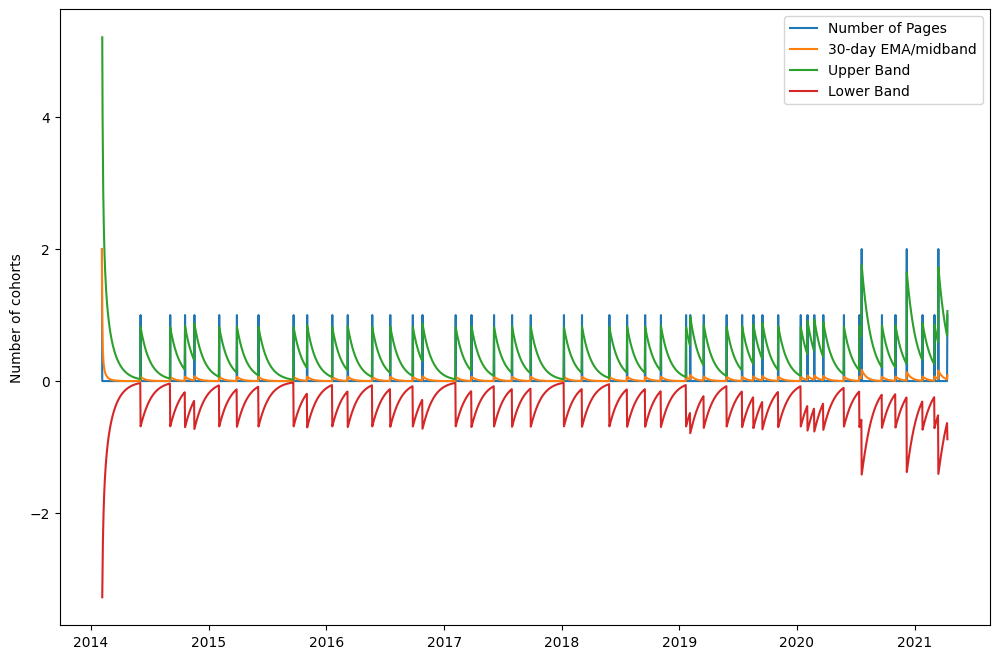

In [76]:
fig, ax = plt.subplots(figsize=(12,8))

ax.plot(my_df.index, my_df.cohort, label='Number of Pages')

ax.plot(my_df.index, my_df.midband, label = '30-day EMA/midband')
ax.plot(my_df.index, my_df.ub, label = 'Upper Band')
ax.plot(my_df.index, my_df.lb, label = 'Lower Band')

ax.legend(loc='best')
ax.set_ylabel('Number of cohorts')

plt.show()

### manually compute %b for the last value in the dataset

In [78]:
# get the value of the last record
last_measure = my_df.iloc[-1].cohort

In [79]:
# get the lower band value on the last date
last_lb = my_df.iloc[-1].lb

In [80]:
# get the upper band value on the last date
last_ub = my_df.iloc[-1].ub

In [81]:
# compute %b
last_pct_b = (last_measure - last_lb)/(last_ub - last_lb)

print('%b for last datapoint: ', round(last_pct_b, 2))

%b for last datapoint:  0.97


### Adding a new column that shows the %b for every record in the dataset (except the first because there are no bollinger bands available for that one record)

In [83]:
my_df['pct_b'] = (my_df['cohort'] - my_df['lb'])/(my_df['ub'] - my_df['lb'])

my_df.head()

,cohort,midband,ub,lb,pct_b
start_date,,,,,
2014-02-04,2,2.000000,NaN,NaN,NaN
2014-02-05,0,0.966667,5.209307,-3.275974,0.386077
2014-02-06,0,0.622732,4.027979,-2.782514,0.408563
2014-02-07,0,0.451147,3.349537,-2.447243,0.422173
2014-02-08,0,0.348500,2.895913,-2.198913,0.431597
